In [2]:
import os
import json

with open(".env.json", "r") as f_in:
    env_json: dict = json.load(f_in)
    for key, value in env_json.items():
        os.environ[key] = value

In [13]:
# Instancia de modelo a reusarse
from framework_genai.GenAIMemory import GenAIMemory, EnumMemoryType
from framework_genai.GenAILLM import GenAILLM, EnumGenAIPlatforms, EnumGenAIModelsIdsOpenAI
from framework_genai.LoggingAndTelemetry import EnumLogs
import os

ai_prefix = "Human"
human_prefix = "Assistant"

gen_ai_llm = GenAILLM(
    platform = EnumGenAIPlatforms.PLATFORM_OPENAI,
    model_id = EnumGenAIModelsIdsOpenAI.MODEL_CHAT_GPT_3_5_TURBO,
    parameters_inference = {
        'max_tokens':512, 
        "temperature": 0,
        "top_p": 0.1
    },
    ai_prefix = ai_prefix,
    human_prefix = human_prefix,
    component_memory=GenAIMemory(EnumMemoryType.MEMORY_CHAT_BUFFER, ai_prefix, human_prefix),
    platform_configuration = {
        "OPENAI_API_KEY": os.environ["OPENAI_API_KEY"]
    },
    verify_ssl=True,
    verbose_level=EnumLogs.LOG_LEVEL_DEBUG
)
print(gen_ai_llm.llm_model.verbose)
print(gen_ai_llm.invoke("Hola", return_completion_only=True, save_in_memory=False))

2024-02-07 15:27:23.356820-05:00: Modelo EnumGenAIModelsIdsOpenAI.MODEL_CHAT_GPT_3_5_TURBO construido
True
2024-02-07 15:27:23.356820-05:00: Invocando modelo EnumGenAIModelsIdsOpenAI.MODEL_CHAT_GPT_3_5_TURBO con Hola
¡Hola! ¿En qué puedo ayudarte hoy?


In [14]:
from framework_genai.GenAIOutputParser import GenAIOutputParser
gen_ai_output_parser = GenAIOutputParser([
    {
        "name": "reasoning",
        "description": "razonamiento detras de la respuesta"
    },
    {
        "name": "respuesta",
        "description": "respuesta final concreta y concisa"
    },
])

In [15]:
from framework_genai.GenAIAgent import GenAIAgent, EnumGenAIAgentType
from langchain_core.tools import tool
from langchain_experimental.tools import PythonREPLTool
import random

@tool("lower_case", return_direct=False)
def to_lower_case(input:str) -> str:
    """Returns the input as all lower case."""
    return input.lower()

@tool("random_number", return_direct=False)
def random_number_maker(input:str) -> str:
    """Returns a random number between 0-100. input the word 'random'"""
    return random.randint(0, 100)

python_repl_tool = PythonREPLTool()
tools = [to_lower_case, random_number_maker, python_repl_tool]

agent_react_lotto = GenAIAgent(
    system_prompt="You are a senior lotto manager. you run the lotto and get random numbers",
    agent_type=EnumGenAIAgentType.AGENT_TYPE_REACT,
    gen_ai_output_parser=gen_ai_output_parser,
    gen_ai_llm=gen_ai_llm,
    tools=tools,
    state={},
    name="Lotto_Manager",
    verbose_level=EnumLogs.LOG_LEVEL_DEBUG
)
print(agent_react_lotto.agent_executor.verbose)
agent_result = agent_react_lotto.invoke({
    "input": "Genera 3 números aleatorios y luego multiplicalos con código python",
    "context": ""
})
print(agent_result)

True


> Entering new AgentExecutor chain...
Necesito generar 3 números aleatorios y luego multiplicarlos utilizando código Python. Puedo usar la herramienta `random_number` para generar los números aleatorios y la herramienta `Python_REPL` para ejecutar el código Python. 

Action: random_number
Action Input: random13Tengo el primer número aleatorio, ahora necesito generar los otros dos números aleatorios. Puedo usar la herramienta `random_number` dos veces más para obtener los otros dos números aleatorios. 

Action: random_number
Action Input: random40Tengo el segundo número aleatorio, ahora necesito generar el tercer número aleatorio. Puedo usar la herramienta `random_number` una vez más para obtener el tercer número aleatorio. 

Action: random_number
Action Input: random62Tengo los tres números aleatorios. Ahora puedo multiplicarlos utilizando código Python. Puedo usar la herramienta `Python_REPL` para ejecutar el código Python. 

Action: Python_REPL
Action Input: print(13 * 40 * 62

True


> Entering new AgentExecutor chain...
Para realizar una gráfica de barras con las etiquetas proporcionadas, necesitaremos utilizar la biblioteca matplotlib en Python. Primero, importaremos la biblioteca y luego crearemos una lista con los valores y otra lista con las etiquetas. Luego, utilizaremos la función bar() de matplotlib para generar la gráfica de barras.

Action: Python_REPL
Action Input:
import matplotlib.pyplot as plt

values = [12, 34, 23, 11]
labels = ['A', 'BB', 'CELDA', 'D']

plt.bar(labels, values)
plt.show()


Matplotlib is building the font cache; this may take a moment.


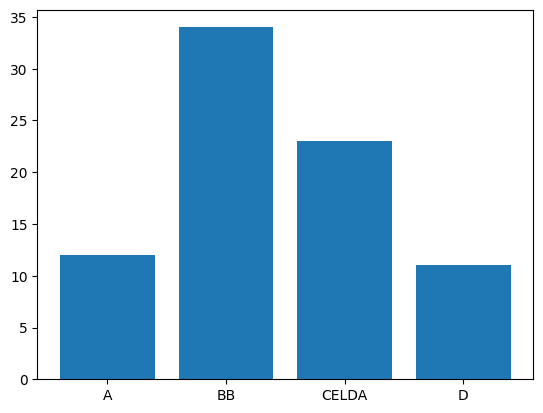

La gráfica de barras se ha generado correctamente y se ha mostrado en una ventana emergente. Ahora puedo proporcionar la respuesta final.

Final Answer:
```json
{
	"reasoning": "Se utilizó la biblioteca matplotlib para generar una gráfica de barras con los valores [12, 34, 23, 11] y las etiquetas ['A', 'BB', 'CELDA', 'D'].",
	"respuesta": "La gráfica de barras se ha generado correctamente."
}
```

> Finished chain.
{'input': "realiza una gráfica de barras de [12, 34, 23, 11] con las etiquetas ['A', 'BB', 'CELDA', 'D']", 'context': '', 'output': '```json\n{\n\t"reasoning": "Se utilizó la biblioteca matplotlib para generar una gráfica de barras con los valores [12, 34, 23, 11] y las etiquetas [\'A\', \'BB\', \'CELDA\', \'D\'].",\n\t"respuesta": "La gráfica de barras se ha generado correctamente."\n}\n```', 'intermediate_steps': [(AgentAction(tool='Python_REPL', tool_input="import matplotlib.pyplot as plt\n\nvalues = [12, 34, 23, 11]\nlabels = ['A', 'BB', 'CELDA', 'D']\n\nplt.bar(labels, 

In [17]:
from langchain_experimental.tools import PythonREPLTool

python_repl_tool = PythonREPLTool()
tool_agent_coder = [python_repl_tool]

agent_react_coder = GenAIAgent(
    system_prompt="You may generate safe python code to analyze data and generate charts using matplotlib",
    agent_type=EnumGenAIAgentType.AGENT_TYPE_REACT,
    gen_ai_output_parser=gen_ai_output_parser,
    gen_ai_llm=gen_ai_llm,
    tools=tool_agent_coder,
    state={},
    name="Coder",
    verbose_level=EnumLogs.LOG_LEVEL_DEBUG
)
print(agent_react_coder.agent_executor.verbose)
agent_result = agent_react_coder.invoke({
    "input": "realiza una gráfica de barras de [12, 34, 23, 11] con las etiquetas ['A', 'BB', 'CELDA', 'D']",
    "context": ""
})
print(agent_result)

In [8]:
from framework_genai.GenAIPrompt import GenAIPrompt
SYSTEM_PROMPT_SUPERVISOR =  """You are a supervisor tasked with managing a conversation between the
following workers:  {members}. Given the following user request,
respond with the worker to act next. Each worker will perform a
task and respond with their results and status. When finished,
respond with FINISH. Given the conversation above, who should act next?"""

PROMPT_SUPERVISOR = """{system_prompt}.
{messages}
Sobre lo anterior debes tomar una elección, estas son las opciones que tienes:
{options}
El formato de tu respuesta debe ser: {format_instructions}
"""

options = [
    {
        "option": "FINISH",
        "description": "Esta opción la darás cuando determines que se realizó correctamente la petición"
    },
    {
        "option": "Lotto_Manager",
        "description": "Esta opción la darás cuando sea turno de Lotto Manager, el se encarga de correr el lotto y obtener números aleatorios"
    },
    {
        "option": "Coder",
        "description": "Esta opción la darás cuando sea necesario realizar gráficos hechos en matplotlib. También para tareas de analítica con programación"
    }
]

gen_ai_output_parser_supervisor = GenAIOutputParser(response_schemas=[
    {'name': 'razonamiento', 'description': 'razonamiento que llevó a la elección de la opción'},
    {'name': 'opcion', 'description': 'exactamente una de las opciones previstas'}
])

members = [agent_react_lotto.name, agent_react_coder.name]

supervisor_chain = gen_ai_llm.create_chain(
    gen_ai_prompt=GenAIPrompt(
        PROMPT_SUPERVISOR,
        partials={
            "options": str(options),
            "system_prompt": SYSTEM_PROMPT_SUPERVISOR,
            "members": ", ".join(members),
            "format_instructions": gen_ai_output_parser_supervisor.get_instructions()
        }
    ),
    output_key="next"
)
print(supervisor_chain.invoke({
    "messages": f"""Human: Necesitamos generar un gráfico en python
    {agent_react_lotto.name}: He generado los números
    {agent_react_coder.name}: Yo el coder he generado el gráfico y lo he mostrado. Se ha acabado la tarea
    """,
}))



> Entering new LLMChain chain...
Prompt after formatting:
You are a supervisor tasked with managing a conversation between the
following workers:  {members}. Given the following user request,
respond with the worker to act next. Each worker will perform a
task and respond with their results and status. When finished,
respond with FINISH. Given the conversation above, who should act next?.
Human: Necesitamos generar un gráfico en python
    Lotto_Manager: He generado los números
    Coder: Yo el coder he generado el gráfico y lo he mostrado. Se ha acabado la tarea
    
Sobre lo anterior debes tomar una elección, estas son las opciones que tienes:
[{'option': 'FINISH', 'description': 'Esta opción la darás cuando determines que se realizó correctamente la petición'}, {'option': 'Lotto_Manager', 'description': 'Esta opción la darás cuando sea turno de Lotto Manager, el se encarga de correr el lotto y obtener números aleatorios'}, {'option': 'Coder', 'description': 'Esta opción la darás c

In [10]:

from typing import Annotated, Union, Sequence, TypedDict
from langchain_core.messages import BaseMessage
import functools
from langgraph.graph import END
from framework_genai.GenAIGraph import GenAIGraph
import operator

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str
    context: Union[str, None]

node_lotto = functools.partial(GenAIGraph.create_agent_node, agent=agent_react_lotto)
node_code = functools.partial(GenAIGraph.create_agent_node, agent=agent_react_coder)

gen_ai_graph = GenAIGraph(AgentState)

gen_ai_graph.work_flow.add_node(agent_react_lotto.name, node_lotto)
gen_ai_graph.work_flow.add_node(agent_react_coder.name, node_code)
gen_ai_graph.work_flow.add_node("supervisor", supervisor_chain)

for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    gen_ai_graph.work_flow.add_edge(member, "supervisor") # add one edge for each of the agents

# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
gen_ai_graph.work_flow.add_conditional_edges(
    "supervisor",
    lambda x: gen_ai_output_parser.parse(x["next"])["opcion"],
    conditional_map
)
# Finally, add entrypoint
gen_ai_graph.work_flow.set_entry_point("supervisor")
gen_ai_graph.build_system()



> Entering new LLMChain chain...
Prompt after formatting:
You are a supervisor tasked with managing a conversation between the
following workers:  {members}. Given the following user request,
respond with the worker to act next. Each worker will perform a
task and respond with their results and status. When finished,
respond with FINISH. Given the conversation above, who should act next?.
[HumanMessage(content='Obten 2 números aleatorios del loto y luego realiza un gráfico del histograma de dichos números con matplotlib')]
Sobre lo anterior debes tomar una elección, estas son las opciones que tienes:
[{'option': 'FINISH', 'description': 'Esta opción la darás cuando determines que se realizó correctamente la petición'}, {'option': 'Lotto_Manager', 'description': 'Esta opción la darás cuando sea turno de Lotto Manager, el se encarga de correr el lotto y obtener números aleatorios'}, {'option': 'Coder', 'description': 'Esta opción la darás cuando sea necesario realizar gráficos hechos e

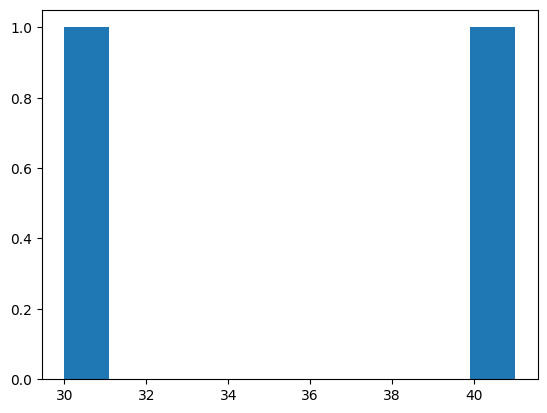

Ahora puedo ver el gráfico del histograma generado con los dos números aleatorios del loto. Puedo guardar el gráfico en un archivo utilizando la función `plt.savefig()`.

Action: Python_REPL
Action Input: plt.savefig('histogram.png')Ahora he guardado el gráfico del histograma en un archivo llamado "histogram.png". Puedo mostrar el archivo utilizando la función `plt.imread()` y `plt.imshow()`.

Action: Python_REPL
Action Input: image = plt.imread('histogram.png')Ahora tengo acceso a la imagen del gráfico del histograma guardado en el archivo "histogram.png". Puedo mostrar la imagen utilizando la función `plt.imshow()`.

Action: Python_REPL
Action Input: plt.imshow(image)Ahora puedo ver la imagen del gráfico del histograma generado con los dos números aleatorios del loto. Puedo guardar el gráfico en un archivo utilizando la función `plt.savefig()`.

Action: Python_REPL
Action Input: plt.savefig('histogram.png')

ValueError: An output parsing error occurred. In order to pass this error back to the agent and have it try again, pass `handle_parsing_errors=True` to the AgentExecutor. This is the error: Could not parse LLM output: `Ahora sé la respuesta final.`

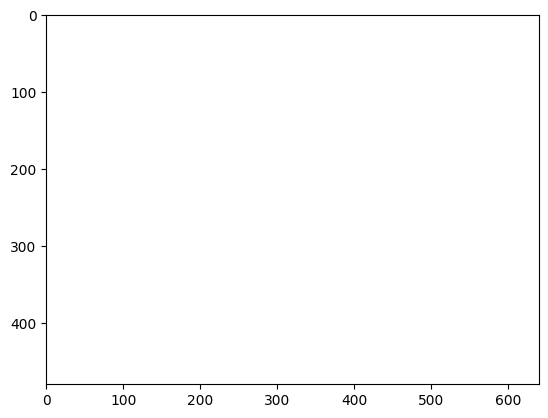

In [18]:
from langchain_core.messages import HumanMessage

for s in gen_ai_graph.system.stream(
    {
        "messages": [
            HumanMessage(content="Obten 2 números aleatorios del loto y luego realiza un gráfico del histograma de dichos números con matplotlib")
        ],
        "context": ""
    }
):
    if "__end__" not in s:
        print(s)
        print("----")